In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd


from examon.examon import Examon
from examon.examon import ExamonQL
import time


KAIROSDB_SERVER = 'examon.cineca.it'
KAIROSDB_PORT = '3000'
USER = ''
PWD = ''


### Marconi Skylake: Sept 2019 Jobs data

In [2]:


ex = Examon(KAIROSDB_SERVER, port=KAIROSDB_PORT, user=USER, password=PWD, verbose=False, proxy=True)
sq = ExamonQL(ex)

t0 = time.time()
data = sq.SELECT('job_id','job_state','end_time','start_time','partition','num_cpus') \
    .FROM('job_info_marconi') \
    .TSTART('29-08-2019 08:09:00') \
    .TSTOP('30-09-2019 08:09:00') \
    .execute_async()

print(time.time() - t0)

df_jobs_sett = pd.read_json(data)
df_jobs_sett.head()

206.71900987625122


job_id  job_state                  end_time                start_time  \
0  5286445  COMPLETED 2019-09-01 04:57:36+00:00 2019-09-01 03:55:37+00:00   
1  5287391     FAILED 2019-09-01 06:21:09+00:00 2019-09-01 06:20:55+00:00   
2  5286160  COMPLETED 2019-09-01 04:22:56+00:00 2019-09-01 03:01:35+00:00   
3  5284721  CANCELLED 2019-08-31 20:45:04+00:00 2019-08-31 20:45:04+00:00   
4  5285330  COMPLETED 2019-09-01 14:13:53+00:00 2019-09-01 02:46:34+00:00   

        partition  num_cpus  
0    knl_usr_prod       272  
1    skl_usr_prod        48  
2  bdw_all_serial         1  
3     skl_usr_dbg         1  
4    skl_usr_prod        48

#### Select Skylake partition

In [3]:
skylake_part = [u'skl_usr_prod', u'skl_fua_prod',u'skl_usr_dbg', u'skl_fua_dbg',u'skl_sys_test']
df_skylake_usage = df_jobs_sett.query('partition in @skylake_part')

df_skylake_usage = df_skylake_usage[['job_id','start_time', 'end_time', 'num_cpus','job_state']]
df_skylake_usage.head()

job_id                start_time                  end_time  num_cpus  \
1   5287391 2019-09-01 06:20:55+00:00 2019-09-01 06:21:09+00:00        48   
3   5284721 2019-08-31 20:45:04+00:00 2019-08-31 20:45:04+00:00         1   
4   5285330 2019-09-01 02:46:34+00:00 2019-09-01 14:13:53+00:00        48   
6   5288059 2019-09-01 08:04:15+00:00 2019-09-01 08:04:28+00:00        48   
11  5284496 2019-09-01 05:44:14+00:00 2019-09-01 09:14:34+00:00       144   

    job_state  
1      FAILED  
3   CANCELLED  
4   COMPLETED  
6      FAILED  
11    TIMEOUT

#### Count the number of Used Cores: 'Util'

In [4]:
df_skylake_usage['duration'] = df_skylake_usage['end_time'] - df_skylake_usage['start_time'] 
# filter jobs with duration <= 5s
df_skylake_usage = df_skylake_usage[df_skylake_usage['duration'] >= pd.Timedelta(5, unit='s')]

df_1 = df_skylake_usage[['job_id', 'start_time', 'num_cpus','job_state']]
df_1.rename(columns={'start_time':'timestamp'},inplace=True)

df_2 = df_skylake_usage[['job_id', 'end_time', 'num_cpus','job_state']]
df_2.rename(columns={'end_time':'timestamp'},inplace=True)
df_2['num_cpus'] = df_2[['num_cpus']].apply(lambda x: -1*x)

df_util = pd.concat([df_1,df_2])
df_util.reset_index(inplace=True)
df_util.drop('index', inplace=True, axis=1)

df_util = df_util.sort_values(by='timestamp', ascending='True')

df_util['util'] = df_util['num_cpus'].cumsum()
df_util.set_index('timestamp', inplace=True)
df_util.head()

/home/beneventi/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-4-857438bf6a1d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['num_cpus'] = df_2[['num_cpus']].apply(lambda x: -1*x)


job_id  num_cpus  job_state  util
timestamp                                                    
2019-08-29 08:10:08+00:00  5265824       192  COMPLETED   192
2019-08-29 08:10:08+00:00  5265825       192  COMPLETED   384
2019-08-29 08:12:14+00:00  5265832       192  COMPLETED   576
2019-08-29 08:12:31+00:00  5265833        48  COMPLETED   624
2019-08-29 08:12:44+00:00  5265833       -48  COMPLETED   576

In [12]:
import matplotlib.pylab as plt
ax = df_util['util'].plot.area(figsize=(14, 9), stacked=False, x_compat=True);
plt.axhline(y=3184*48, linestyle='-.',color='r');
ax.set_title('Unibo data - Marconi-Skylake: Used Cores - 09/2019');
ax.set_ylabel('Cores#');

### Marconi Skylake: Sept 2019 Nagios Data

In [6]:
from examon.examon import Examon
from examon.executors import ExDask
from examon.examon import ExamonQL
import time

ex = Examon(KAIROSDB_SERVER, port=KAIROSDB_PORT, user=USER, password=PWD, verbose=False, proxy=True)
sq = ExamonQL(ex)

t0 = time.time()
df_nag = sq.SELECT('node','description','state','host_group') \
    .FROM('plugin_output') \
    .WHERE(plugin='nagios_pub', cluster='marconi', description='batchs::client::state', 
           host_group='skl-a3\,skl , skl-a5\,skl , skl-a4\,skl') \
    .TSTART('01-09-2019 00:00:00') \
    .TSTOP('30-09-2019 23:59:59') \
    .execute_async(n_workers=4, threads_per_worker=2, processes=True, batch_size=7*60*60*1000, dashboard_address=':4040', 
                         memory_limit='0')


print(time.time() - t0)
df_nag.head()

/home/beneventi/miniconda3/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 4040 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34305 instead
  warnings.warn(


Query(tstart='01-09-2019 00:00:00', tstop='30-09-2019 23:59:59', metrics=['plugin_output'], tags={'plugin': ['nagios_pub'], 'cluster': ['marconi'], 'description': ['batchs::client::state'], 'host_group': ['skl-a3,skl', 'skl-a5,skl', 'skl-a4,skl']}, groupby=[{'name': 'tag', 'tags': ['node', 'description', 'state', 'host_group']}], aggrby=None, limit=None, time_zone='Europe/Rome')
77.67734456062317


node            description state  host_group           name  \
0  r129c01s01  batchs::client::state     0  skl-a3,skl  plugin_output   
1  r129c01s01  batchs::client::state     0  skl-a3,skl  plugin_output   
2  r129c01s01  batchs::client::state     0  skl-a3,skl  plugin_output   
3  r129c01s01  batchs::client::state     0  skl-a3,skl  plugin_output   
4  r129c01s01  batchs::client::state     0  skl-a3,skl  plugin_output   

       timestamp                         value  
0  1567415700027   IDLE matches only ok states  
1  1567416600009  IDLE* matches only ok states  
2  1567417500100  IDLE* matches only ok states  
3  1567418400100  IDLE* matches only ok states  
4  1567419300100  IDLE* matches only ok states

In [15]:
df_nag.shape

(8708240, 7)

In [16]:
df_nag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8708240 entries, 0 to 76415
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   node         category      
 1   description  category      
 2   state        int64         
 3   host_group   category      
 4   name         category      
 5   timestamp    datetime64[ns]
 6   value        object        
dtypes: category(4), datetime64[ns](1), int64(1), object(1)
memory usage: 307.4+ MB


In [7]:
# convert the 'timestamp' column to 'datetime' type
df_nag['timestamp'] = pd.to_datetime(df_nag['timestamp'], unit='ms')

# convert the 'state' column to 'numeric' type
df_nag['state'] = pd.to_numeric(df_nag['state'], errors='coerce')

df_nag_sett = pd.pivot_table(df_nag, index="timestamp", columns="state", values="node", aggfunc="count")

df_nag_sett['Total Nodes'] = df_nag_sett[0]+df_nag_sett[2]
df_nag_sett.head()

state                       0   2  Total Nodes
timestamp                                     
2019-09-02 09:15:00.027  3164  20         3184
2019-09-02 09:30:00.009  3164  20         3184
2019-09-02 09:45:00.100  3164  20         3184
2019-09-02 10:00:00.100  3164  20         3184
2019-09-02 10:15:00.100  3164  20         3184

In [13]:
# Plot
import matplotlib.pylab as plt
import matplotlib.dates as mdates

days = mdates.WeekdayLocator() 
df_usg = df_nag_sett[['Total Nodes',2]]
df_usg.rename(columns={2: "Not Avail."}, inplace=True)

ax = df_usg.plot.area(figsize=(18, 9), stacked=False, x_compat=True, color=['g', 'r', 'b', 'c']);
ax.set_title('Unibo data - Marconi-Skylake: Nagios - batchs::client::state - 09/2019');
ax.set_ylabel('Nodes#');
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.show()

/home/beneventi/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


### Total Nodes, Used, Not Available

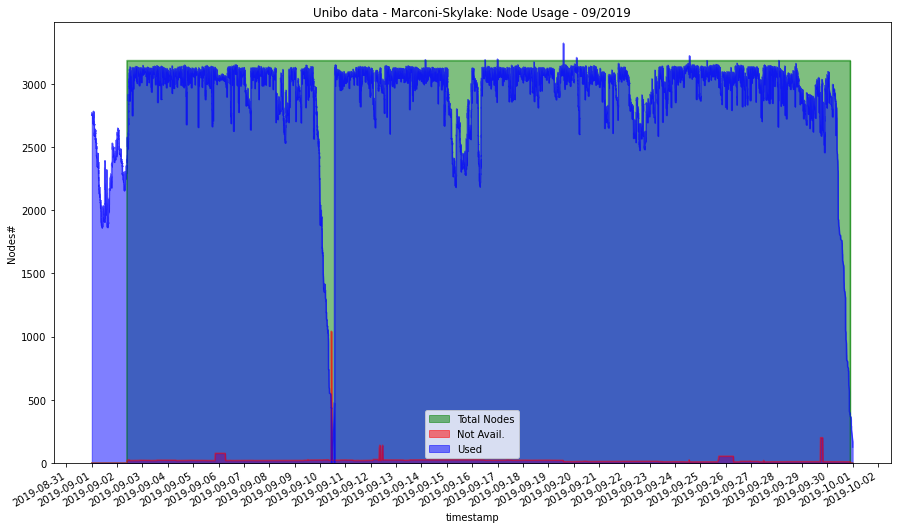

In [14]:
import datetime
import matplotlib.pylab as plt
import matplotlib.dates as mdates

NCORES_PER_NODE = 48  #marconi skylake

days = mdates.WeekdayLocator() 

df_nagios_sett_avail = df_usg
df_usage_ncores_sett = df_util['util']/NCORES_PER_NODE

df_nagios_sett_avail = df_nagios_sett_avail.tz_localize('UTC')

df_view_sett = pd.merge(df_nagios_sett_avail ,df_usage_ncores_sett, how='outer', left_index=True, right_index=True).interpolate(method='time',limit_area='inside')

st = pd.to_datetime('2019-09-01').tz_localize('UTC')
et = pd.to_datetime('2019-10-01').tz_localize('UTC')

df_view_sett = df_view_sett.query('(timestamp >= @st) & (timestamp <= @et)')

df_view_sett.rename(columns={"util": "Used"}, inplace=True)

ax = df_view_sett.plot.area(figsize=(15, 9), stacked=False, x_compat=True, color=['g', 'r', 'b', 'y', 'k']);
ax.set_title('Unibo data - Marconi-Skylake: Node Usage - 09/2019');
ax.set_ylabel('Nodes#');
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.show()